### Retrieval-Augmented Generation (RAG) - Basic Method
This notebook demonstrates the initial implementation of RAG with fundamental indexing, retrieval, and generation techniques.
##### Key Highlights:
- **Basic Indexing**:  
  This approach does not employ advanced techniques like K-Nearest Neighbors (KNN) search to identify relevant documents. Instead, it focuses on straightforward indexing mechanisms.
- **Basic Retrieval and Generation**:  
  The retrieval and generation methods used here are foundational, designed for simplicity and ease of understanding.
##### What's Next: 
Split documents based on tokens, Retrieval custom number of chunks using KNN, Custom Prompt, Pipe Chaining for modularity. 

#### Install required libraries

In [1]:
# Install required libraries
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Import required libraries

In [2]:
import os # Operating system relevant tasks
from dotenv import load_dotenv
import bs4 # Import Beautiful Soap, a Python Web Scrapping package
from langchain_community.document_loaders import WebBaseLoader # Load documents from website
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma # Import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain import hub # Python library containing pre-defined Prompts, Chains for LLM applications
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

USER_AGENT environment variable not set, consider setting it to identify your requests.


#### Environment Setup

In [3]:
# Load environment variables from .env file
load_dotenv()

# API key provides authentication to access LangChain service 
os.environ['LANGCHAIN_TRACING_V2'] = 'true' # Enables LangChain Tracing V2, a mechanism to enable and monitor the execution of LangChain applications for debugging and optimization
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com' # Configures the LangChain API End Point to use LangChain for tracing
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
# API key to access OpenAI services
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

#### RAG Process

In [4]:
## Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load() 

## Split the documents
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(blog_docs)

## Calculate the vector embeddings of the splits, store in the vector store and convert the vector store into a retriever object
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings()) # Store the vector embeddings of splits in Chroma DB
retriever = vectorstore.as_retriever() # Convert the vector store into a retriever

## Retrieve RAG specific prompt
prompt = hub.pull("rlm/rag-prompt") # Fetches RAG specific PROMPT template

## Define LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

#### RAG Chain

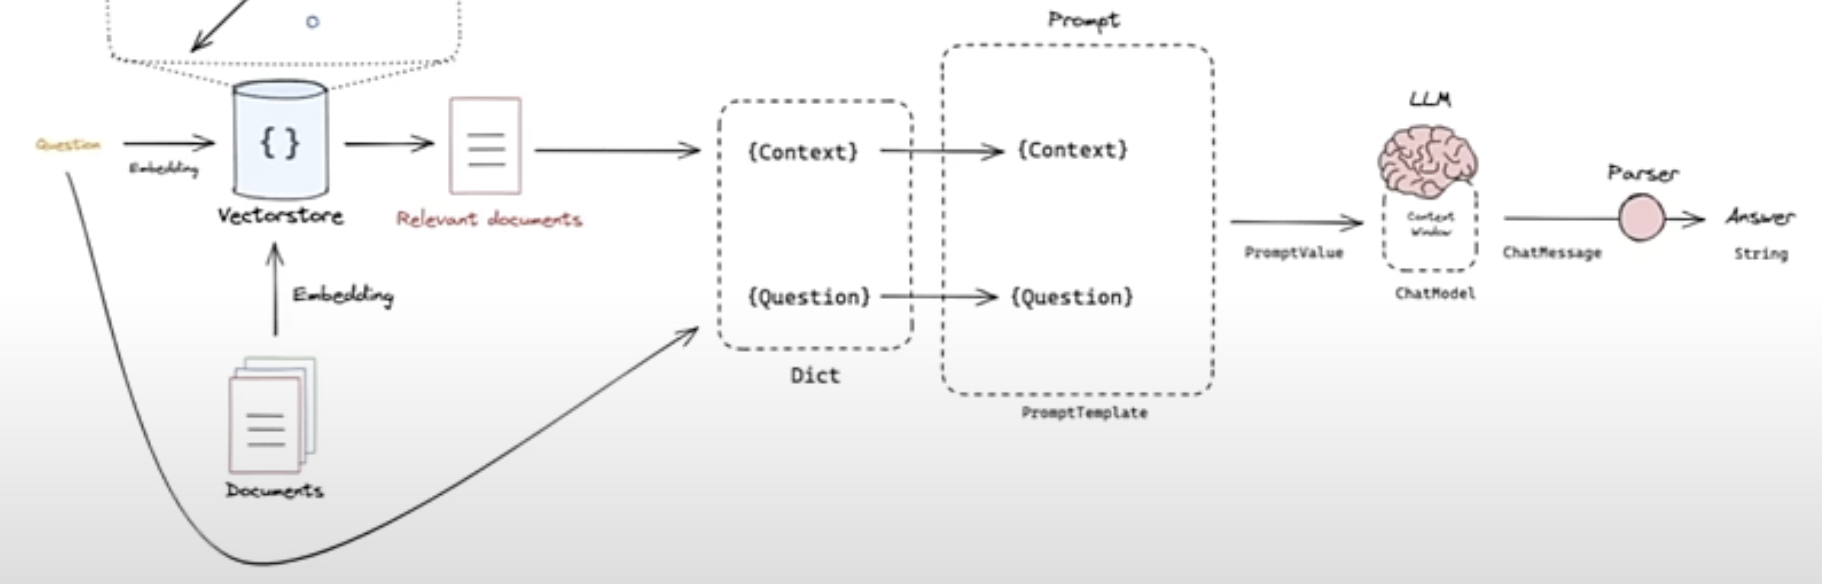

Explanation of rag_chain
- The retriever fetches the relevant documents from the vector store based on the question and format them into a single string. This becomes the context for the prompt.
- "question": RunnablePassthrough(): This passes the question input directly to the next step of the chain.
- prompt: The context and question becomes the kind of keys in the dictionary as specified in the prompt template selected and shown in the above picture.
- Output Parser ensures that the output from the LLM is user-friendly string.

In [5]:
# Post-processing - Function to perform post processing on collection documents. Converts list of documents to a single string
## Extract the page content from each document and join the documents into a single string, separating them by '\n\n' for readability
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

#### Invoke LLM 

In [6]:
rag_chain.invoke("What is Task Decomposition?")

'Task Decomposition is a technique used to break down complex tasks into smaller and simpler steps. This approach allows agents to plan and execute tasks more efficiently by dividing them into manageable components. Task decomposition can be achieved through various methods such as using prompting techniques, task-specific instructions, or human inputs.'

**Few Takeaways:**

Why Use Beautiful Soap Python package?
- To scrape data from web pages.
- To clean and restructure HTML or XML documents.
- To find elements using tags, classes, or attributes.

What is LangSmith?
- A platform for building production grade LLM applications
- Compare results across models, architectures and prompts to identify what works best
- Quickly refine prompts to achieve more accurate and reliable results
- LangSmith integrate seamlessly with LangChain's open source frameworks, *langchain* and *langgraph* with no extra instrumentation needed.
https://docs.smith.langchain.com